<a href="https://colab.research.google.com/github/Kr-stof/cartpole/blob/main/Cartpole%20-%20Lab%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pygame==2.5.2 --only-binary :all:
!pip install gym==0.25.2 --no-deps
!pip install gym[classic_control] --no-deps
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

## Importing Dependencies & Defining Helper Functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')

  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''
    <video alt="test" autoplay loop controls style="height: 400px;">
      <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
    '''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Loading CartPole Environment

In [ ]:
env = gym.make("CartPole-v1")

### Action Space

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


### Observation Space

| Num | Observation           | Min                 | Max                |
| :-: | :-------------------: | :-----------------: | :----------------: |
| 0   | Cart Position         | -4.8                | 4.8                |
| 1   | Cart Velocity         | -INF                | INF                |
| 2   | Pole Angle            | ~ -0.418 RAD (-24°) | ~ 0.418 RAD (-24°) |
| 3   | Pole Angular Velocity | -INF                | INF                |

The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.03120268  0.02169537  0.04616714  0.00295623]


### Reward

For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.03424992 -0.3698063   0.05242307  0.6167362 ]
Reward for this step: 1.0
Is this round done? False


### Starting State

All observations are assigned a uniformly random value in (-0.05, 0.05).

### Episode End

The episode ends if any one of the following occurs:
Termination: Pole Angle is greater than ±12°
Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
Truncation: Episode length is greater than 500.

### Example

Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
  observation, reward, done, info = env.step(0)
  cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL Agent

### Deep Q-Network

I have decided to opt for the implementation of the DQN RL algorithm as it is the most optimal algorithm from the ones covered in the lecture for this task for the reasons listed below.
- The env has a continuous State Space, which Q-Learning cannot handle without discretization.
- DQN allows generalization across continuous inputs.

#### DQN Theoretical Background

- *Note: Observation and State may be use interchangably throughout the project.*
- My implementation is based on the following algorithm, Deep Q-Learning using Experience Replay, i.e., storing a fixed number of the most recently collected
transitions for training.
- The algorithm is a modified version of the Q-Learning algorithm included in the lecture notes.
- I will be referring back to this algorithm throughout the explaination of my code.
- **Summary of logic which will be adapted from the algorithm:**
  - *Note: Preprocessing the observation sequence is not required for CartPole, as image input is not involved.*
  - `Q` Represents the agent's action-value function approximator (DQN), estimating Q(s, a), i.e., the expected return from taking action a in state s.
  - `D` Replay memory used to store past transitions (state, action, reward, next state, done).
  - `EPSILON` Controls exploration in ε-greedy policy (random VS best action).
  - For each timestep, the agent:
    - Selects action `a[t]` and observes reward `r[t]`, next state `s[t + 1]` and `done[t]` flag.
    - Stores the transition (`s[t]`,`a[t]`,`r[t]`,`s[t + 1]`, `done[t]`) in replay memory `D`.
    - Periodically, the agent samples previously stored transition data from memory `D` (Prioritized Experience Replay is used instead of random sampling, this means an extra variable `priority[t]` will be added into replay memory in my implementation).
    - For each transition (`s[j]`,`a[j]`,`r[j]`,`s[j + 1]`, `done[j]`) `y[j]`, i.e., the TD target is computed:
      - If `done[j]` is true (i.e., next state is terminal):
        - `y[j] = r[j]`
      - If `done[j]` is false:
        - `y[j] = r[j] + GAMMA * max(Q(s[j + 1], a)`
      - Compute the loss as the MSE between the TD target and the predicted Q-Value for the taken action:
        - `loss = (y[j] - Q(s[j], a[j]))^2`
      - Finally, compute TD Error for Prioritized Experience Replay, and update `priority[j]` in the replay memory:
        - `td_error = y[j] - Q(s[j], a[j])`
        - `priority[j] = td_error + 1e-6`

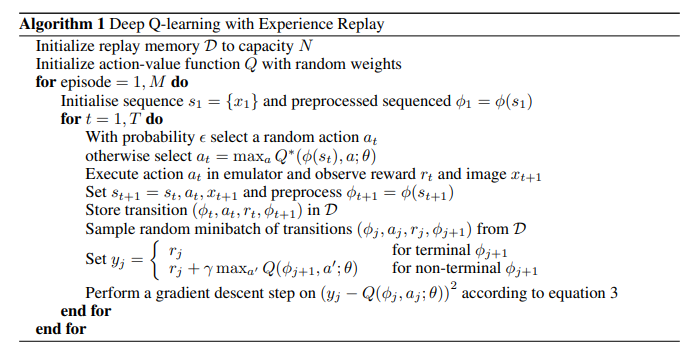

*Note: The intial idea, libraries, optimal hyperparameters are taken from PyTorch Tutorial (see references), however the code is implemented based on my explanation and interpretation of the algorithm displayed above.*

#### Importing Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

#### DQN Class

- Intialize the NN with the input being a 4-dimensional observation (cart position, cart velocity, pole angle, pole angular velocity) and output 2 Q-Values (left, right).
- `nn.Sequential` contains the layers of the NN in order: Input → "Blackbox" replacing Q table used in Q-Learning (Hidden Layers) → Output.
- The `forward()` method returns Q(s, :), i.e., a Q-value for each action given a state s.
- The hidden layer applies a `Linear()` transformation followed by a `ReLU()` activation, enabling the network to model complex non-linear mappings between states and Q-values.
- In the code when `agent(observation_tensor)` is called `forward()` is executed implicitly.

In [ ]:
class DQN(nn.Module):
  def __init__(self, observation_dimension, action_dimension):
    super(DQN, self).__init__()
    self.model = nn.Sequential (
      nn.Linear(observation_dimension, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, action_dimension))
  def forward(self, x):
    return self.model(x)

#### Implementation & Training of DQN Agent

##### Hyperparameters

- `EPISODE_CNT` Total number of episodes to train the agent
- `GAMMA` Discount factor for future rewards
- `LR` Learning rate for optimizer
- `EPSILON` Initial exploration rate (90% random at start)
- `EPSILON_DECAY` Rate at which epsilon decays per episode
- `EPSILON_MIN` Minimum exploration rate (ensures continued exploration)
- `TRANSITION_SIZE` Transition size required for training
- `MEMORY_LIMIT` Maximum size of replay memory (older transitions get removed)

In [ ]:
EPISODE_CNT = 600
GAMMA = 0.99
LR = 1e-4
EPSILON = 0.9
EPSILON_DECAY = 0.999
EPSILON_MIN = 0.01
TRANSITION_SIZE = 128
MEMORY_LIMIT = 10000

##### DQN Agent Setup

- Building a neural network with:
  - `observation_dimension` input Layer: 4 neurons (1 for each observation value)
  - `action_dimension` output Layer: 2 neurons (2 Q-values for left, right)
- `agent` instantiation
- `optimizer` instantiation
- `memory` collection for storing transitions (replay memory)
- `loss_fn` MSE between TD target and predicted Q-Values

In [ ]:
observation = env.reset()
observation_dimension = 4
action_dimension = 2
agent = DQN(observation_dimension, action_dimension)
optimizer = torch.optim.Adam(agent.parameters(), lr = LR)
memory = deque(maxlen=MEMORY_LIMIT)
loss_fn = nn.MSELoss()

##### Epsilon-Greedy Action Selection

- Exploration Step
  - With probability `EPSILON`, take a random action
  - Encourages exploring the environment early in training
- Exploitation Step
  - Use the trained DQN to select the best action
  - `observation_tensor` observation array converted into a PyTorch Tensor so it can be input into the DQN model.
  - `q_values` estimating Q-Values for all actions
  - `action` picking the action with the highest Q-value

In [ ]:
def select_action(observation, EPSILON):
  if random.random() < EPSILON:
    action = random.randint(0, 1)
    return action
  with torch.no_grad():
    observation_tensor = torch.FloatTensor(observation)
    # Get Q-Values learnt in previous training steps
    # Q(s[t], a[t])
    q_values = agent(observation_tensor)
    # Select best action from Q-Values
    # PI(s) = argmax Q(s[t], a[t])
    action = torch.argmax(q_values).item()
    return action

##### Prioritized Experience Replay

- PER's goal is to sample and replay events according to their importance in enhancing the learning process, presents a priority system.
- PER prioritizes each experience according to the size of the TD error instead of randomly selecting all experiences.

In [ ]:
def PER_sample(memory, TRANSITION_SIZE):
  # Extract priorities from memory
  priorities = np.array([transition[5] for transition in memory])
  # Probability of choosing a transition has to be a number between 0 and 1 inclusive
  probabilities = priorities / priorities.sum()
  # Choose 128 (TRANSITION_SIZE) transitions randomly from the memory, prioritizing those with highest priorities
  indices = np.random.choice(len(memory), TRANSITION_SIZE, p = probabilities)
  transitions = [memory[i] for i in indices]
  return transitions, indices

##### Training Loop

In [ ]:
episode_rewards = []

for episode in range(EPISODE_CNT):
  observation = env.reset()
  done = False
  cumulative_reward = 0

  while not done:
    # Select action a[t]
    action = select_action(observation, EPSILON)
    # Observe next state, reward, done flag
    # s[t + 1], r[t], done[t] = s[t], a[t]
    next_observation, reward, done, _ = env.step(action)
    # Store transition in replay memory
    # (s[t], a[t], r[t], s[t + 1], done[t], priority[t]) into D
    memory.append((observation, action, reward, next_observation, done, 1.0))

    observation = next_observation
    cumulative_reward += reward

    # Start training if enough transitions are stored in the memory
    if len(memory) >= TRANSITION_SIZE:
      # Sample previously stored transition data from memory
      # Sample transition data count: 128 (TRANSITION_SIZE)
      # (s[j], a[j], r[j], s[j + 1], done[j], priority[j]) from D
      transitions, indicies = PER_sample(memory, TRANSITION_SIZE)
      transition_observations, transition_actions, transition_rewards, transition_next_observations, transition_done_flags, transition_priorities = zip(*transitions)

      # Convert into PyTorch Tensors so they can be input into the DQN model
      # Tensors with shape: [128]
      transition_observations = torch.FloatTensor(transition_observations)
      transition_actions = torch.LongTensor(transition_actions)
      transition_rewards = torch.FloatTensor(transition_rewards)
      transition_next_observations = torch.FloatTensor(transition_next_observations)
      transition_done_flags = torch.FloatTensor(transition_done_flags)

      # Get the predicted Q-Values
      # Select Q-values for the taken actions only, shape: [128]
      # Q(s[j], a[j])
      predicted_q_values = agent(transition_observations).gather(1, transition_actions.unsqueeze(1)).squeeze(1)

      # TD target
      # y[j] = r[j] + GAMMA * max(Q(s[j + 1], a[t])
      with torch.no_grad():
        # V(s[j + 1]) = max(Q(s[j + 1], a[t])
        next_q_value = agent(transition_next_observations).max(1)[0]
        td_targets = transition_rewards + GAMMA * next_q_value * (1 - transition_done_flags)

      # Compute Mean Squared Error loss between predicted Q-values and target TDs
      # loss = (y[j] - Q(s[j], a[j]))^2
      loss = loss_fn(td_targets, predicted_q_values)
      # Apply gradient descent, i.e., minimize loss function
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute the TD Errors
      # td_errors = (y[j] - Q(s[j], a[j])) + 1e-6 (Prevent 0 priority)
      td_errors = torch.abs(td_targets - predicted_q_values).detach().numpy()

      # Update priorities in the memory
      for index, td_error in zip(indicies, td_errors):
        memory[index] = (*memory[index][:5], td_error + 1e-6)

  EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)
  episode_rewards.append(cumulative_reward)
  print(f"(Episode {episode:>3}), (Reward: {cumulative_reward:>5}), (Epsilon: {EPSILON:>4.3f})")

(Episode   0), (Reward:  32.0), (Epsilon: 0.899)
(Episode   1), (Reward:  26.0), (Epsilon: 0.898)
(Episode   2), (Reward:  21.0), (Epsilon: 0.897)
(Episode   3), (Reward:  16.0), (Epsilon: 0.896)
(Episode   4), (Reward:  19.0), (Epsilon: 0.896)
(Episode   5), (Reward:  14.0), (Epsilon: 0.895)


<ipython-input-15-3123c1c87996>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  transition_observations = torch.FloatTensor(transition_observations)


(Episode   6), (Reward:  34.0), (Epsilon: 0.894)
(Episode   7), (Reward:  28.0), (Epsilon: 0.893)
(Episode   8), (Reward:  25.0), (Epsilon: 0.892)
(Episode   9), (Reward:  21.0), (Epsilon: 0.891)
(Episode  10), (Reward:  17.0), (Epsilon: 0.890)
(Episode  11), (Reward:  20.0), (Epsilon: 0.889)
(Episode  12), (Reward:  11.0), (Epsilon: 0.888)
(Episode  13), (Reward:  19.0), (Epsilon: 0.887)
(Episode  14), (Reward:  21.0), (Epsilon: 0.887)
(Episode  15), (Reward:  36.0), (Epsilon: 0.886)
(Episode  16), (Reward:  22.0), (Epsilon: 0.885)
(Episode  17), (Reward:  14.0), (Epsilon: 0.884)
(Episode  18), (Reward:  16.0), (Epsilon: 0.883)
(Episode  19), (Reward:  35.0), (Epsilon: 0.882)
(Episode  20), (Reward:  16.0), (Epsilon: 0.881)
(Episode  21), (Reward:  17.0), (Epsilon: 0.880)
(Episode  22), (Reward:  12.0), (Epsilon: 0.880)
(Episode  23), (Reward:  20.0), (Epsilon: 0.879)
(Episode  24), (Reward:   9.0), (Epsilon: 0.878)
(Episode  25), (Reward:  23.0), (Epsilon: 0.877)
(Episode  26), (Rewa

#### Output for Task 1 after Training of Agent is completed

In [ ]:
observation_tensor = torch.FloatTensor(observation)
q_values = agent(observation_tensor)
print(f"(Action : Q-Values): (0 : {q_values[0].item()}), (1 : {q_values[1].item()})")

# For training following was used:
# action = select_action(observation, EPSILON)
# Code rewritten so printing of q_values is possible
action = torch.argmax(q_values).item()

print("Observation:", observation)
print("Chosen action by DQN agent:", action)

(Action : Q-Values): (0 : -1166.7760009765625), (1 : 1253.422119140625)
Observation: [-1.8324368  -1.8780123   0.21347854  1.3196428 ]
Chosen action by DQN agent: 1


## Task 2: Demonstrate the effectiveness of the RL Agent

In [ ]:
TEST_EPISODE_CNT = 100
test_episode_rewards = []

for episode in range(TEST_EPISODE_CNT):
  observation = env.reset()
  done = False
  cumulative_reward = 0

  while not done:
    action = select_action(observation, 0.0)
    observation, reward, done, _ = env.step(action)
    cumulative_reward += reward

  test_episode_rewards.append(cumulative_reward)
  print(f"(Episode {episode:>2}), (Reward: {cumulative_reward:>4})")

(Episode  0), (Reward: 487.0)
(Episode  1), (Reward: 500.0)
(Episode  2), (Reward: 306.0)
(Episode  3), (Reward: 500.0)
(Episode  4), (Reward: 500.0)
(Episode  5), (Reward: 500.0)
(Episode  6), (Reward: 425.0)
(Episode  7), (Reward: 500.0)
(Episode  8), (Reward: 500.0)
(Episode  9), (Reward: 438.0)
(Episode 10), (Reward: 301.0)
(Episode 11), (Reward: 463.0)
(Episode 12), (Reward: 500.0)
(Episode 13), (Reward: 500.0)
(Episode 14), (Reward: 324.0)
(Episode 15), (Reward: 493.0)
(Episode 16), (Reward: 500.0)
(Episode 17), (Reward: 421.0)
(Episode 18), (Reward: 500.0)
(Episode 19), (Reward: 500.0)
(Episode 20), (Reward: 500.0)
(Episode 21), (Reward: 417.0)
(Episode 22), (Reward: 359.0)
(Episode 23), (Reward: 500.0)
(Episode 24), (Reward: 500.0)
(Episode 25), (Reward: 344.0)
(Episode 26), (Reward: 500.0)
(Episode 27), (Reward: 500.0)
(Episode 28), (Reward: 500.0)
(Episode 29), (Reward: 500.0)
(Episode 30), (Reward: 325.0)
(Episode 31), (Reward: 357.0)
(Episode 32), (Reward: 481.0)
(Episode 3

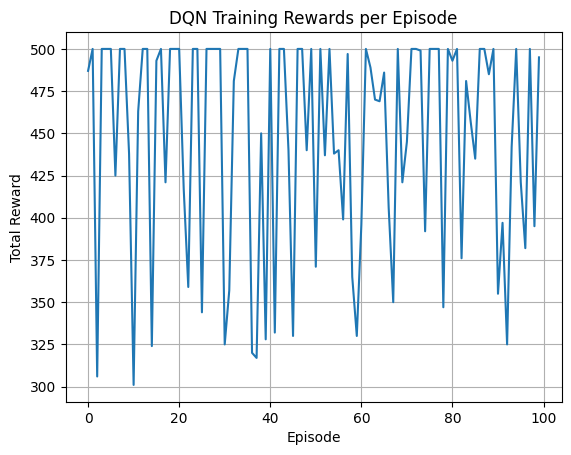

In [ ]:
mean_test_reward = np.mean(test_episode_rewards)
plt.plot(test_episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Rewards per Episode")
plt.grid(True)
plt.show()

In [ ]:
print("Average cumulative reward:", mean_test_reward)
print("Is my agent good enough?", mean_test_reward > 195)

Average cumulative reward: 447.84
Is my agent good enough? True


## Task 3: Render an Episode played by the Agent

In [ ]:
# Numpy attribute error fix
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_

# Video Rendering will only work if the following directory exists,
# "MyDrive/ColabNotebooks" in your Google Drive.
# Ensure access is given to Google Drive Desktop to write to your Google Drive.
# from google.colab import drive

# If the Notebook is saved in your Google Drive uncomment these two lines and
# comment out second video_path
# drive.mount("/content/drive")
# video_path = "/content/drive/MyDrive/ColabNotebooks"

video_path = "./video"

env = RecordVideo(gym.make("CartPole-v1"), video_path)
observation = env.reset()
done = False

while not done:
  env.render()
  action = select_action(observation, 0.0)
  observation, reward, done, _ = env.step(action)

env.close()

In [ ]:
show_video()

## References:
> https://arxiv.org/abs/2007.06700<br>
> https://arxiv.org/abs/1312.5602<br>
> https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html<br>
> https://www.geeksforgeeks.org/understanding-prioritized-experience-replay/<br>
> https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code<br>